# Food delivery time prediction

Justyna Gibas 403122 <br>
Jan Pomykacz 401623 

# Introduction
The goal of our project is to predict food delivery time. Model can be used by companies to estimate delivery time based on distance, order time etc, and notify their customers when food should arrive. Such notification are implemented in services (e.g Pyszne.pl), but often they're incorrect.

# Technical remarks
Models were fitted and sampled in script "models_fitting.py". Prior and posterior predictive checks were done in "model.ipynb". Reason for so many files was hardware limitation of our computers (not enough RAM). In this raport we analyzed outcomes of our project.

# Dataset
In project we use data from Kaggle only from file train.csv (https://www.kaggle.com/datasets/gauravmalik26/food-delivery-dataset?select=train.csv).  Both numerical and categorical variable are available. Data comes from orders in India. Dataset contain information about:
-	order ID and delivery person ID,
-	delivery person age and rating,
-	coordinates of restaurant,
-	coordinates of delivery location,
-	order date and time,
-	pickup time (by delivery person),
-	weather conditions,
-	traffic,
-	vehicle type and it’s condition,
-	type of food ordered,
-	city type, 
-	information if there is a festival,
-	number of deliveries,
-	number of simultaneously delivered orders,
-	delivery time (in minutes). <br><br>

We don’t take into consideration IDs, information about festivals (they are very rare, 1-2% of data) and vehicle condition (values aren’t described)



# DAG

On our dag we used following notation:
- continuous lines - indicates association between block, the thicker it is the stronger association,
- dashed lines - indicates weak influence between data,
- continuous border - data was present in dataset,
- dashed border - data wasn't present in dataset e.g. meal preparation time was calculated based on data,
- white blocks - data wasn't used in models,
- blue blocks -  predictor used in first model,
- yellow blocks -  additional predictors used in second model,
- red block - predicted data.
<br><br>
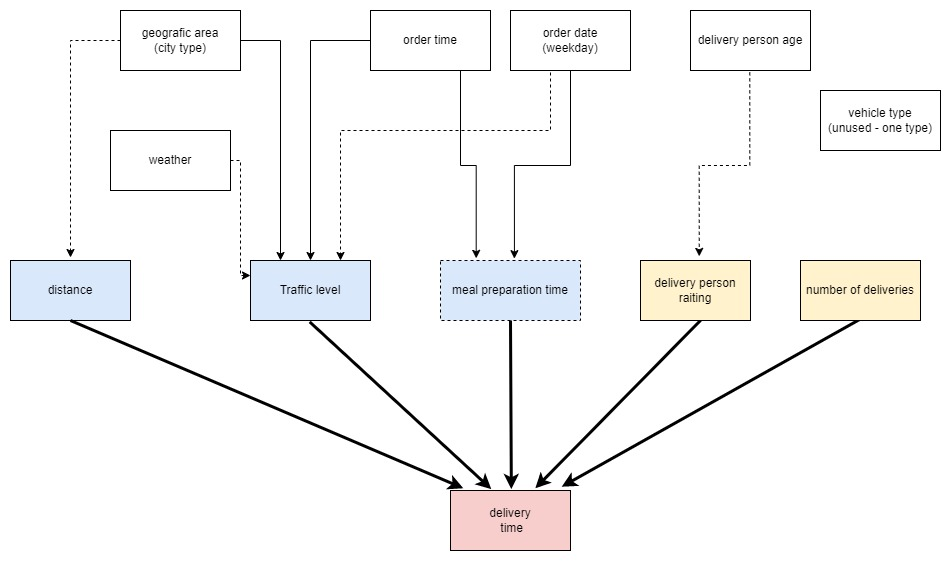

# Possible confoundings

### Forks
- distance and traffic level have common cause of geographic area,
- traffic level and meal preparation time have common causes of order time and order date (two forks on the same predictors).

### Colliders
- traffic level is influenced by weather, order time, geographic area and order date,
- meal preparation time is influenced by order time and order date,
- delivery time is influenced by blue blocks group from DAG, delivery person rating and number of deliveries. We specified blue blocks as one group because more or less they're associated with each other, so i.e. distance and traffic level do not form a collider on delivery time, for they share a common cause.

### Pipes
- delivery person age is transmitted through delivery person rating to delivery time,
- weather is transmitted through traffic level to delivery time.

# Data Preprocessing

To prepare data for modelling and to understand them better we took the following steps:
1.	delete wrong coordinates – Some records contain coordinates that don’t belong to India e.g. ocean point. We remove them because we can't create road paths between this points.
2.	remove records containing nulls – We don’t consider missing or corrupted predictors/data, because they make prediction impossible.
3.	calculate meal preparation time – There was only date and time for order and pick up by delivery person. We calculate time in minutes to simplify modelling.
4.	delete impossible delivery times – Some records contain delivery time that is lower or equal to meal preparation time. We assumed that meal preparation time is part of delivery time so those records would have negative travel time.
5.	converting coordinates to road distance – We mapped the coordinates to a distance to better match the actual delivery route. We used OpenStreetMaps API. Some created routes have incorrect distances or failed to create.
6.	removing corrupted routes – There were some issue with routing – road distances was lower than straight line distance, so we removed them. 
7.	filtering data – We assumed that maximum delivery distance is around 20km. In modelling we used records that have distances lower or equal to 20km.
8.  mapping categorical (string) data to numerical – In our models we use categorical traffic level variable, but models cannot use non-numerical predictors. 
9. data standadrization - We had problem with link function (exp), because data is widely spread. We decide to standarize distance, meal preparation time and delivery person ratings for easier modeling and interpretation.
10. remapping multiple_deliveries - We used it as index variables so we need to adjust it values to stan indexing - mapped  0-3 to 1-4.  

Note that only filtering, mapping and standardization are done in notebook.  You can find data after preprocessing (steps 1-6) in file delivery_time_data.csv. 


## The distributions of data used in models

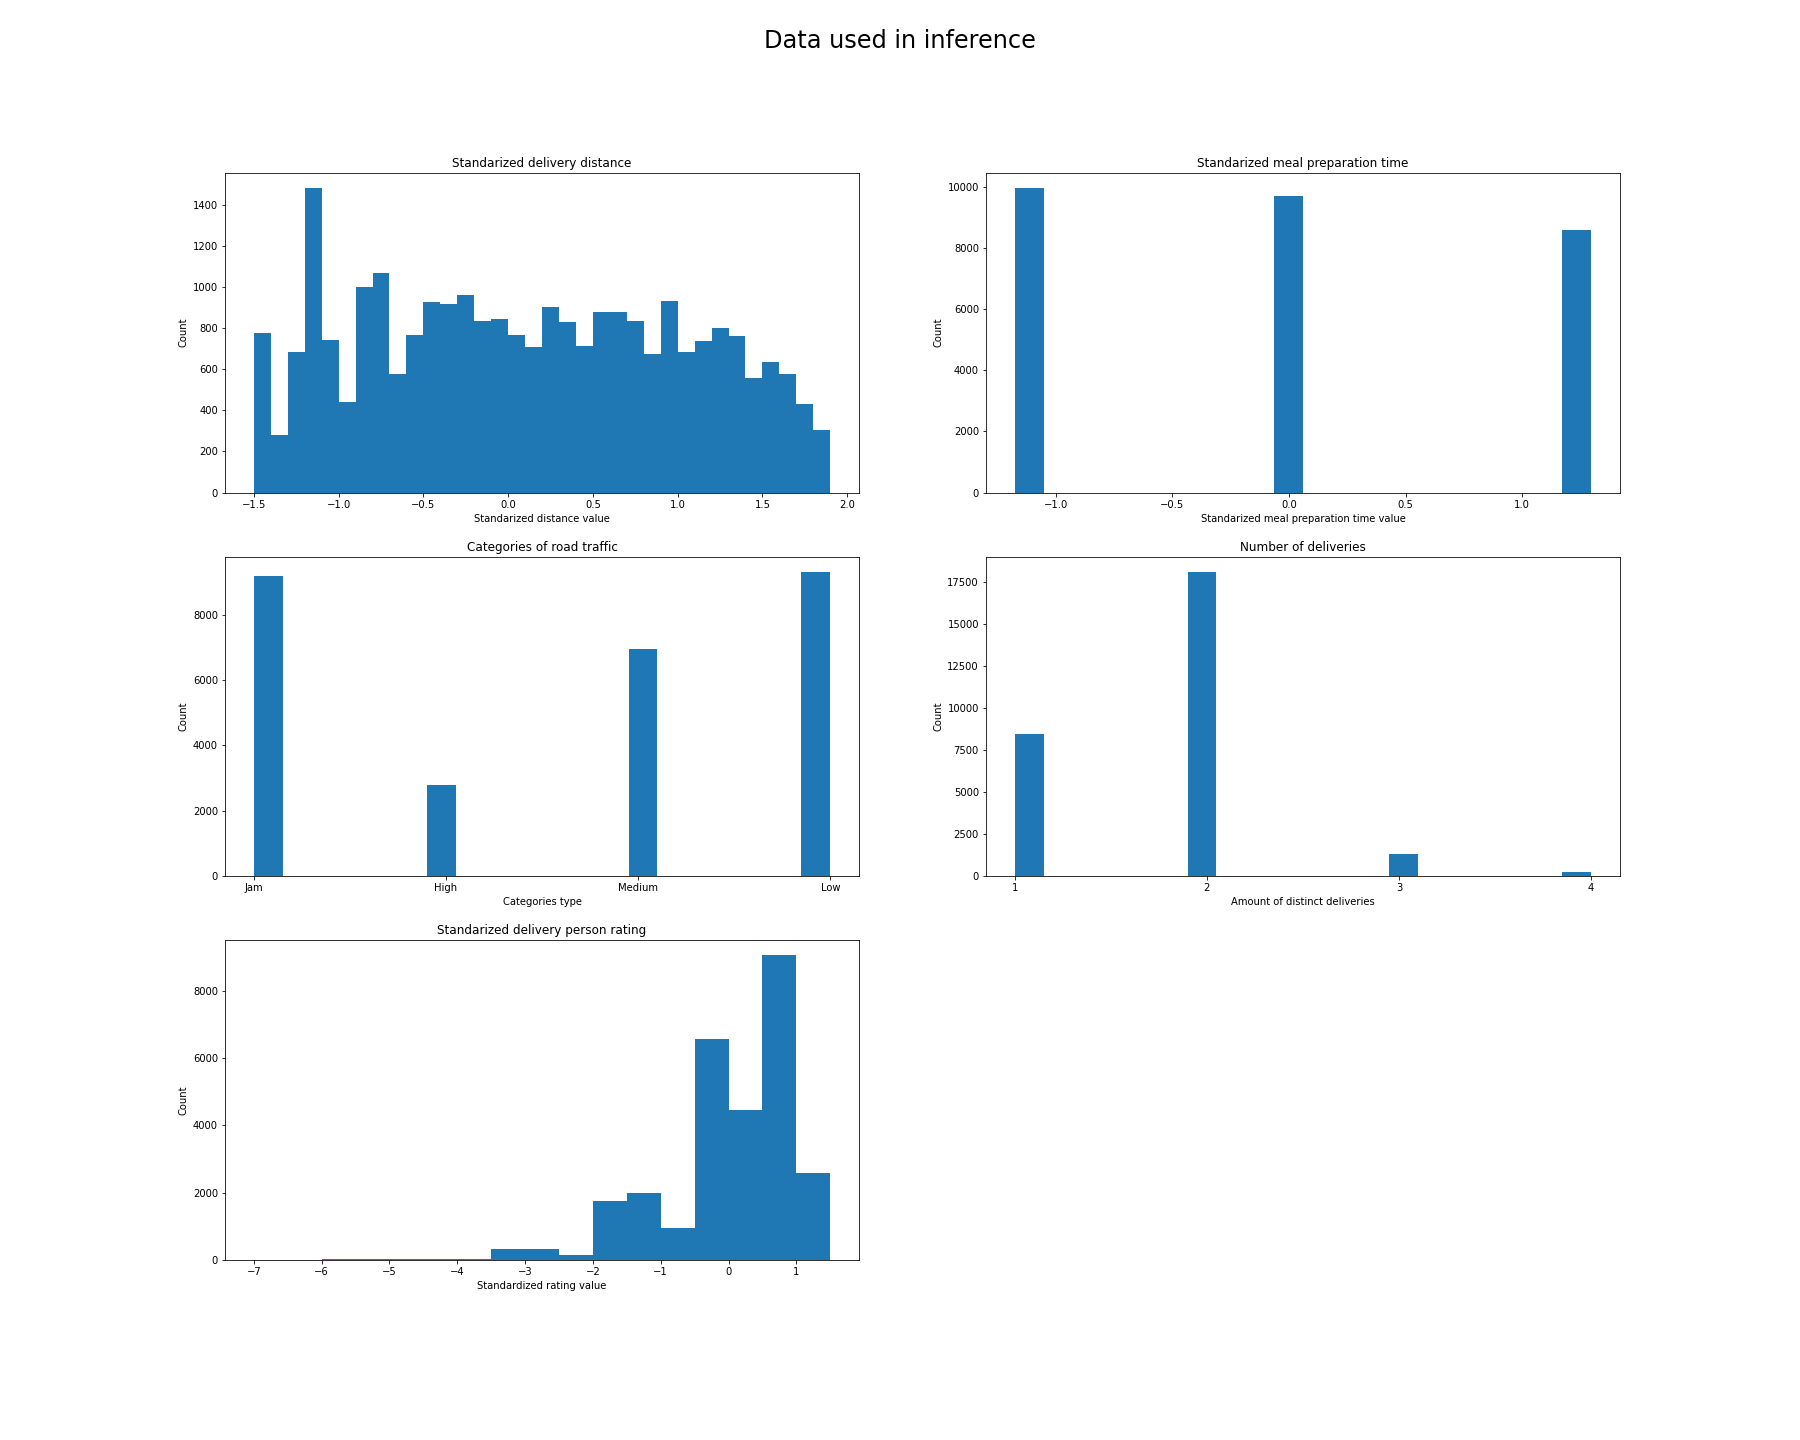

# Models description

We designed two models to make a delivery time prediction. Both models are generalized linear models. We used logarithmic link function for linear combination of predictors to transform their domain to positive real numbers. It was necessary for inverse gamma distribution, which we used to model the delivery time. In second model we additionally took into account parameters describing delivery person – his/her rating and number of deliveries. In first model we used parameters that we consider most important. The other model is supposed to extend the first one. By adding more parameters (information about delivery) we wanted to see if it would improve prediction or overcomplicate the model.



## Model 1

### Inputs

N - number of samples <br>
distance - vector containing standarized distances <br>
traffic_level - numerical array containing infromation about traffic level (1-Jam, 2-High, 3-Medium, 4-Low) <br>
meal_preparation_time - vector containing standarized meal preparation time <br>

### Parameters

$\mu$ - average time of delivery for given parameters, used for calculation of invgamma parameters $\alpha$ and $\beta$ <br>
$\sigma$ - standard deviation of delivery time, used for calculation of invgamma parameters $\alpha$ and $\beta$ <br>
mean - it represents time of average delivery, intercept in link function <br>
distance_coeff - coefficient of distance, used in link function <br>
meal_prep_coeff - coefficient of meal preparation time, used in link function <br>
traffic_level_coeff - vector of traffic level coefficients, used in link function <br>


### Formulas

$$ delivery\_time_{i} \sim InvGamma(\alpha_{i}, \beta_{i})$$
$$ \alpha_i=\frac{\mu_i^2}{\sigma_i^2}+2$$
$$ \beta=\frac{\mu_i^3}{\sigma_i^2}+\mu_i $$
$$ \sigma_i \sim Exponential\left(0.5\right)$$
$$ \mu_i = exp(distance\_coeff_{i} \cdot distance_{i} +  traffic\_level\_coeff[traffic\_level_{i}]\ + meal\_prep\_coeff_{i}\ \cdot  meal\_preparation\_time_{i} + mean_{i}) $$
$$ mean_{i} \sim Normal(3,0.1)$$ 
$$ distance\_coeff_{i}  \sim Normal(0,0.3)$$ 
$$ meal\_prep\_coeff_{i} \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff_{i} \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[1] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[2] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[3] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[4] \sim Normal(0,0.3)$$

## Model 2

### Inputs

N - number of samples <br>
distance - vector containing standardized distances <br>
traffic_level - numerical array containing infromation about traffic level (1-Jam, 2-High, 3-Medium, 4-Low) <br>
meal_preparation_time - vector containing standardized meal preparation times <br>
delivery_person_rating - array containing standardized rating of delivery person <br>
number_of_deliveries - array containing information about additional deliveries <br>

### Parameters
$\mu$ - average time of delivery for given parameters, used for calculation of invgamma parameters $\alpha$ and $\beta$ <br>
$\sigma$ - standard deviation of delivery time, used for calculation of invgamma parameters $\alpha$ and $\beta$  <br>
mean - intercept in link function, it represents time of average delivery <br>
distance_coeff - coefficient of distance, used in link function <br>
meal_prep_coeff - coefficient of meal preparation time, used in link function <br>
traffic_level_coeff - vector of traffic level coefficients, used in link function <br>
person_rating_coeff - coefficient of delivery preson raiting, used in link function<br>
deliveries_number_coeff - vector of coefficients corresponding to number of multiple deliveries, used in link function<br>

### Formulas

$$ delivery\_time_{i} \sim InvGamma(\alpha_{i}, \beta_{i})$$
$$ \alpha_i=\frac{\mu_i^2}{\sigma_i^2}+2$$
$$ \beta=\frac{\mu_i^3}{\sigma_i^2}+\mu_i $$
$$ \sigma_i \sim Exponential\left(0.5\right)$$
$$ \mu_i = exp(distance\_coeff_{i} \cdot distance_{i}+traffic\_level\_coeff[traffic\_level_{i}]\ + meal\_prep\_coeff_{i}\ \cdot  meal\_preparation\_time_{i} + \\ + person\_rating\_coeff_{i} \cdot delivery\_person\_rating_{i} +  deliveries\_number\_coeff[number\_of\_deliveries_{i}] + mean_{i})$$ 
$$ mean_{i} \sim Normal(3,0.1)$$ 
$$ distance\_coeff_{i}  \sim Normal(0,0.3)$$ 
$$ meal\_prep\_coeff_{i} \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff_{i} \sim Normal(0,0.3)$$
$$ person\_rating\_coeff_{i} \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[1] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[2] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[3] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[4] \sim Normal(0,0.3)$$
$$ deliveries\_number\_coeff[1] \sim Normal(0,0.3)$$
$$ deliveries\_number\_coeff[2] \sim Normal(0,0.3)$$
$$ deliveries\_number\_coeff[3] \sim Normal(0,0.3)$$
$$ deliveries\_number\_coeff[4] \sim Normal(0,0.3)$$

# Model 1 - Priors 

We decided to choose weakly informative priors, because we have a lot of data and as the number of datapoint increases, priors will have less and less influence on the model. We have standardized data, so for most parameters we choose normal distribution with mean=0 and standard deviation = 0.3. They were supposed to be resemble normal(0,1) distribution, but we needed to take into account exponentiation of the predictors, so sigma was scaled down to limit the output values.<br>
Parameter *mean* is intercept of linear combination representing time of average delivery. It is stronger prior, with distribution of normal(3,0.1). It was picked based on internet articles regarding Zomato food delivery, where average delivery time was around 15-30 minutes.<br>

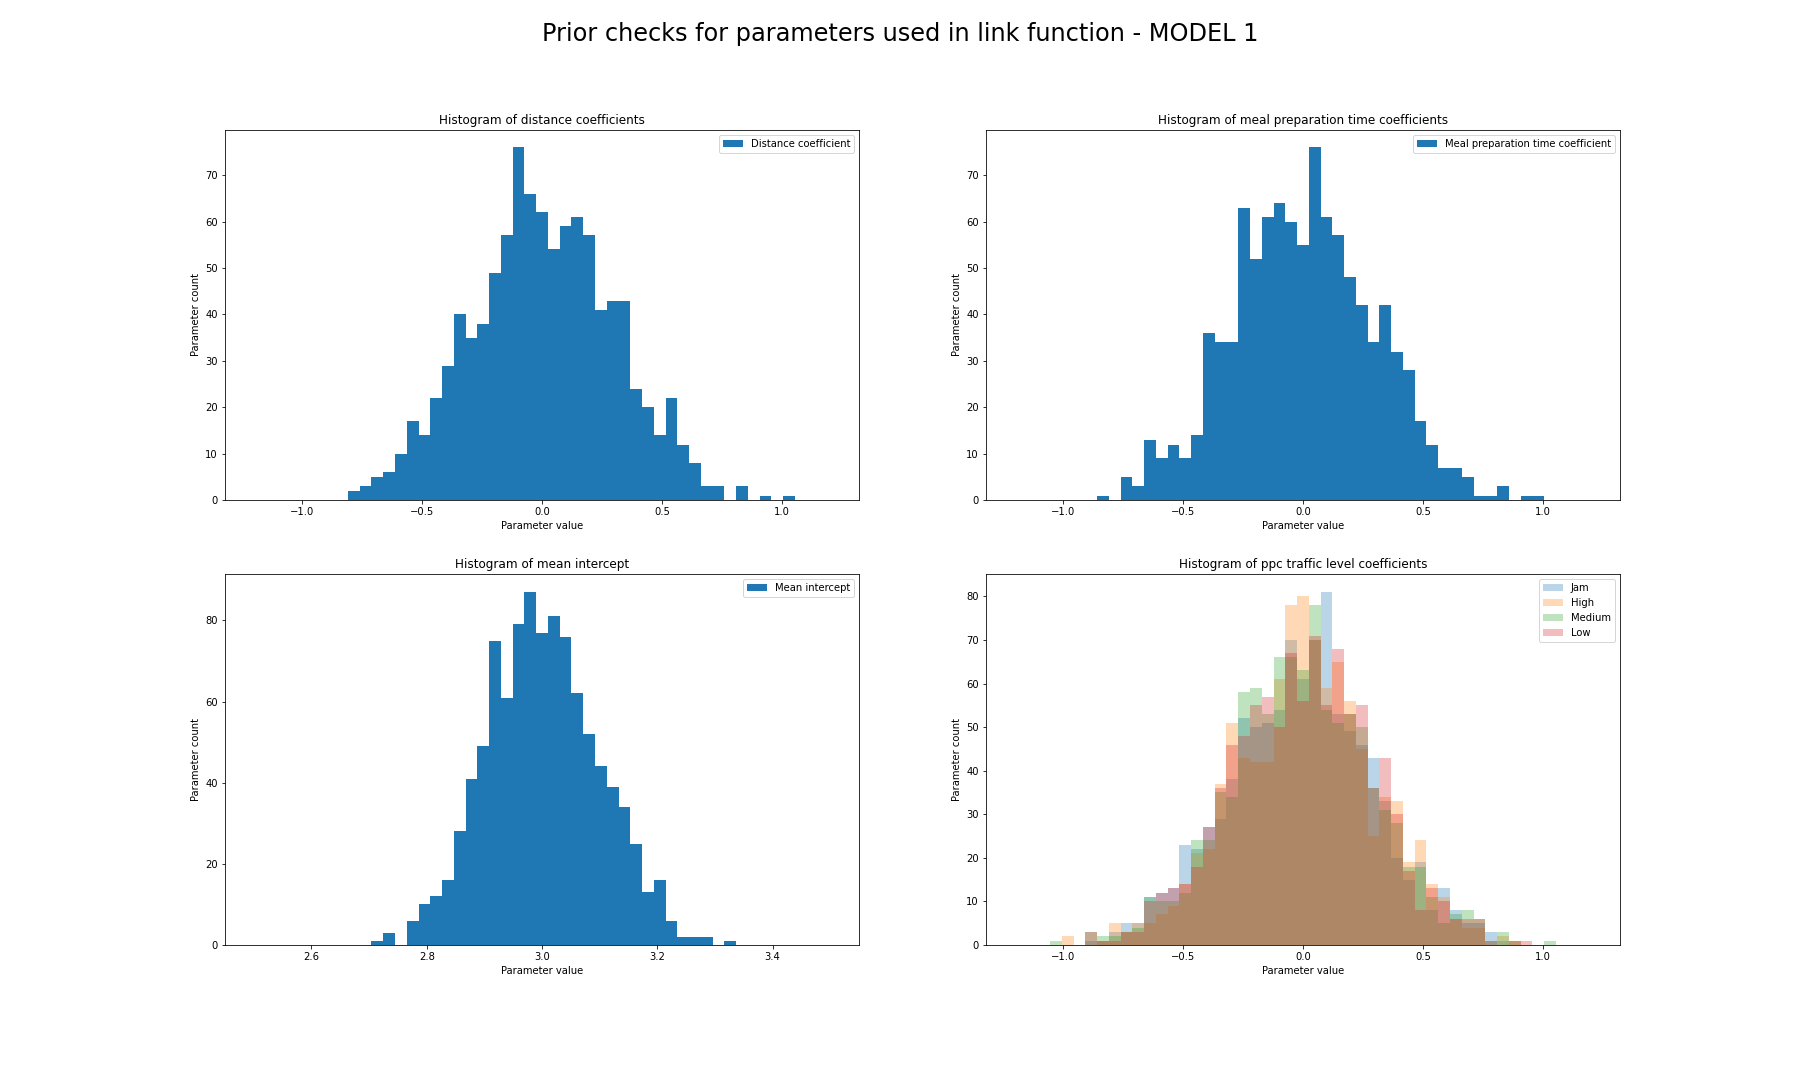 <br> <br>

Values of predictors coefficients are randomly generated and there are no irregularities. They follow their distributions.<br> <br> <br> <br>

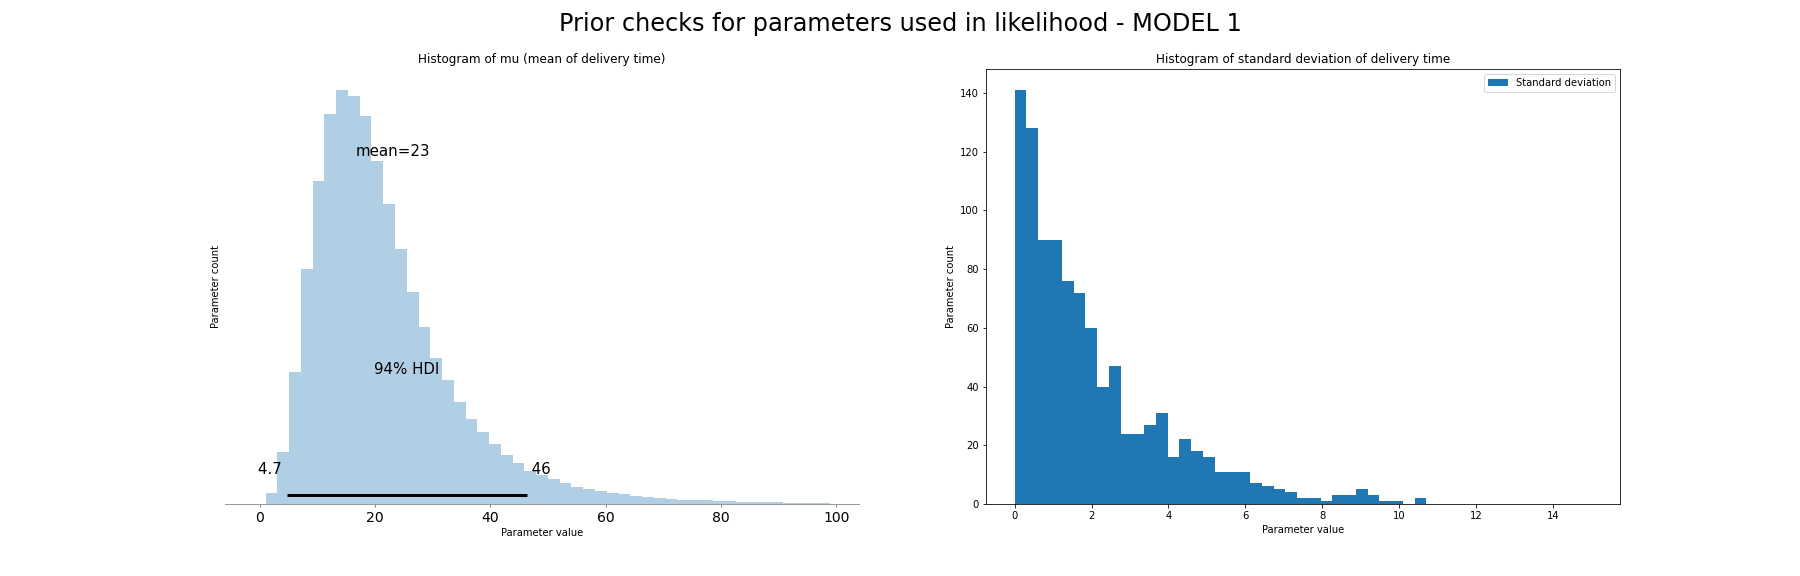 <br> <br>
Parameter $\mu$ has reasonable values. Distribution has long tail, but as seen on the plot 94% of its values are between 5-45 minutes. Also we didn't obtain highly improbable results (like thousands). <br>
Standard deviation $\sigma$ follows its priors. 
 <br> <br> <br> <br>

 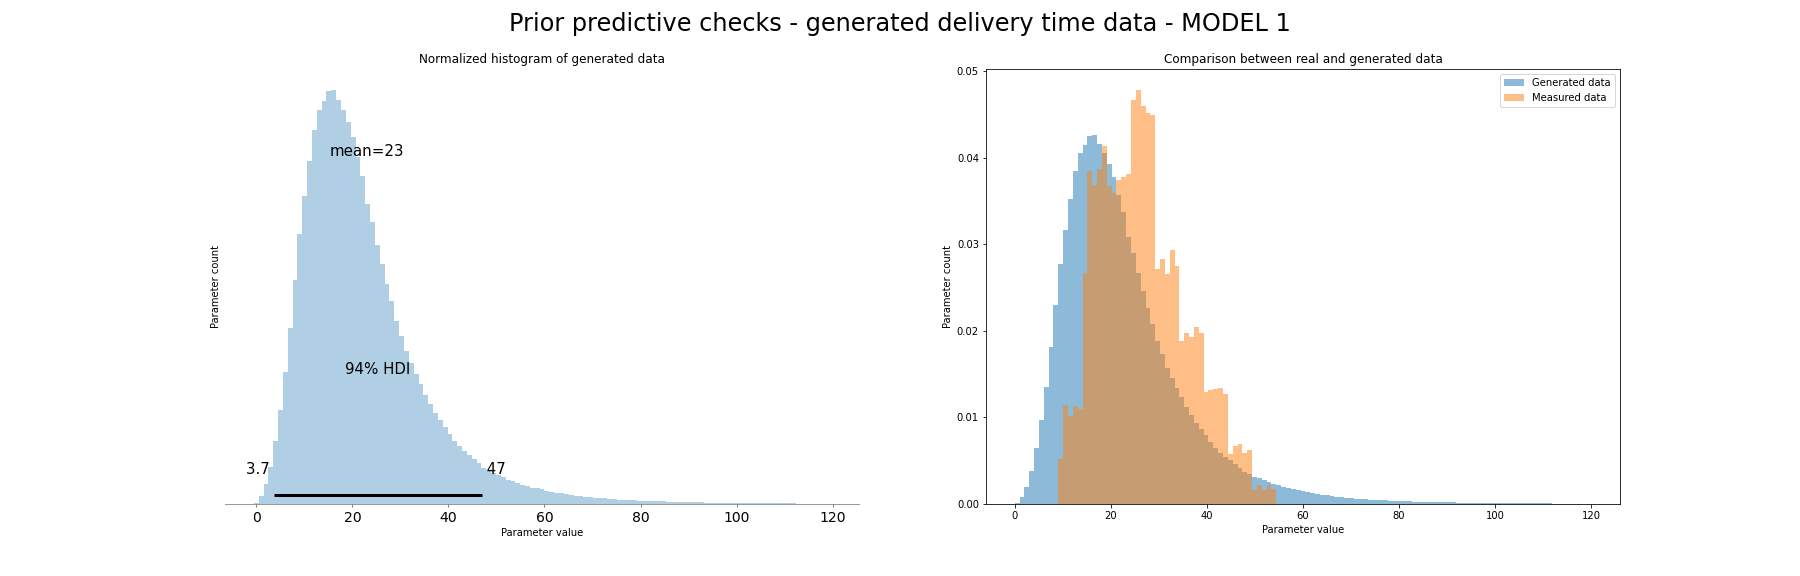 <br> <br>
Real data are possible to observe in priors, which we wanted to happen, although they didn't overlap so well, which we supposed could happen. 



# Model 1 - Posterior

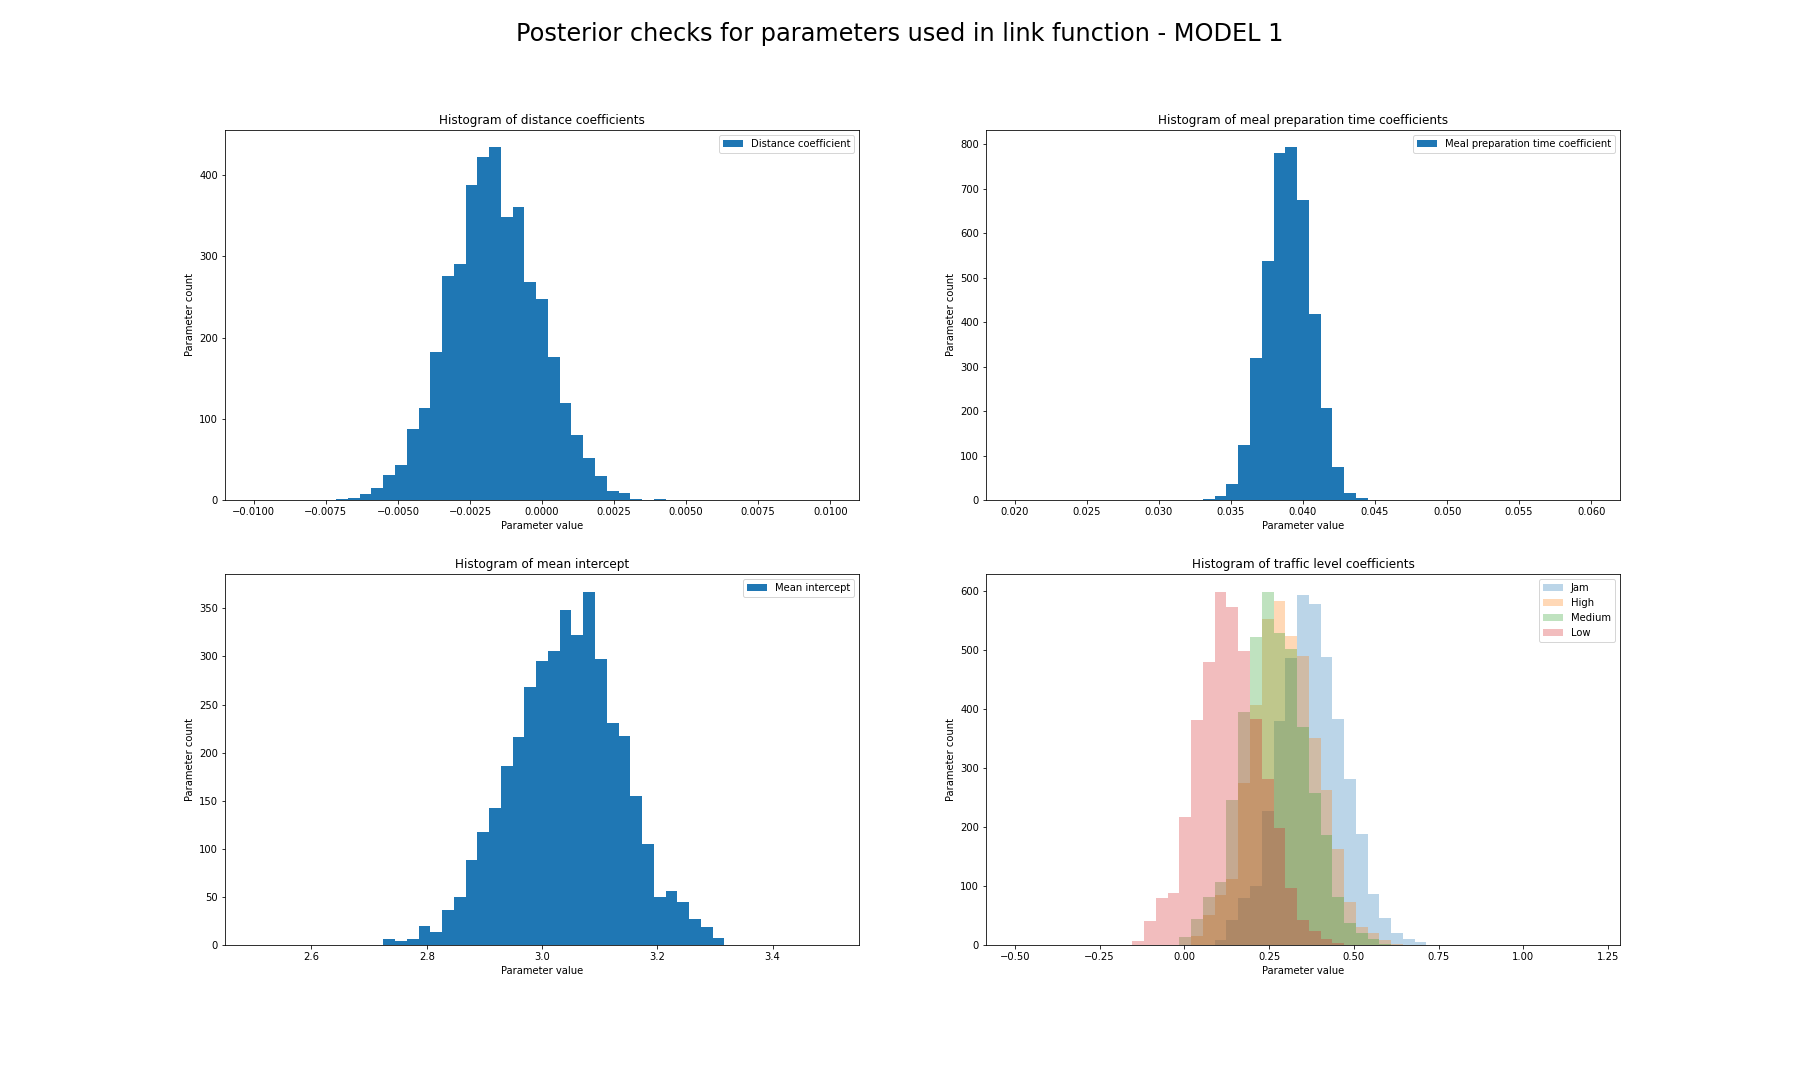 <br> <br>
In most cases posterior distribution for parameters are  narrower (except paramterer mean), but we expected such behaviour, given big number of data. <br>
Surprisingly most values of distance coefficient are negative. This indicates that distance is inversly related to delivery time. By inverse relation we mean that waiting time for shorter distances is longer than expected. <br>
On plot of  level coefficients we can see that histograms for every level follow similar distributions, but with different means. As expected values for jam are the highest, for low are the lowest.  For medium and high traffic values are very similar. It may be caused by smaller sample size of those categoriers.<br><br><br><br>
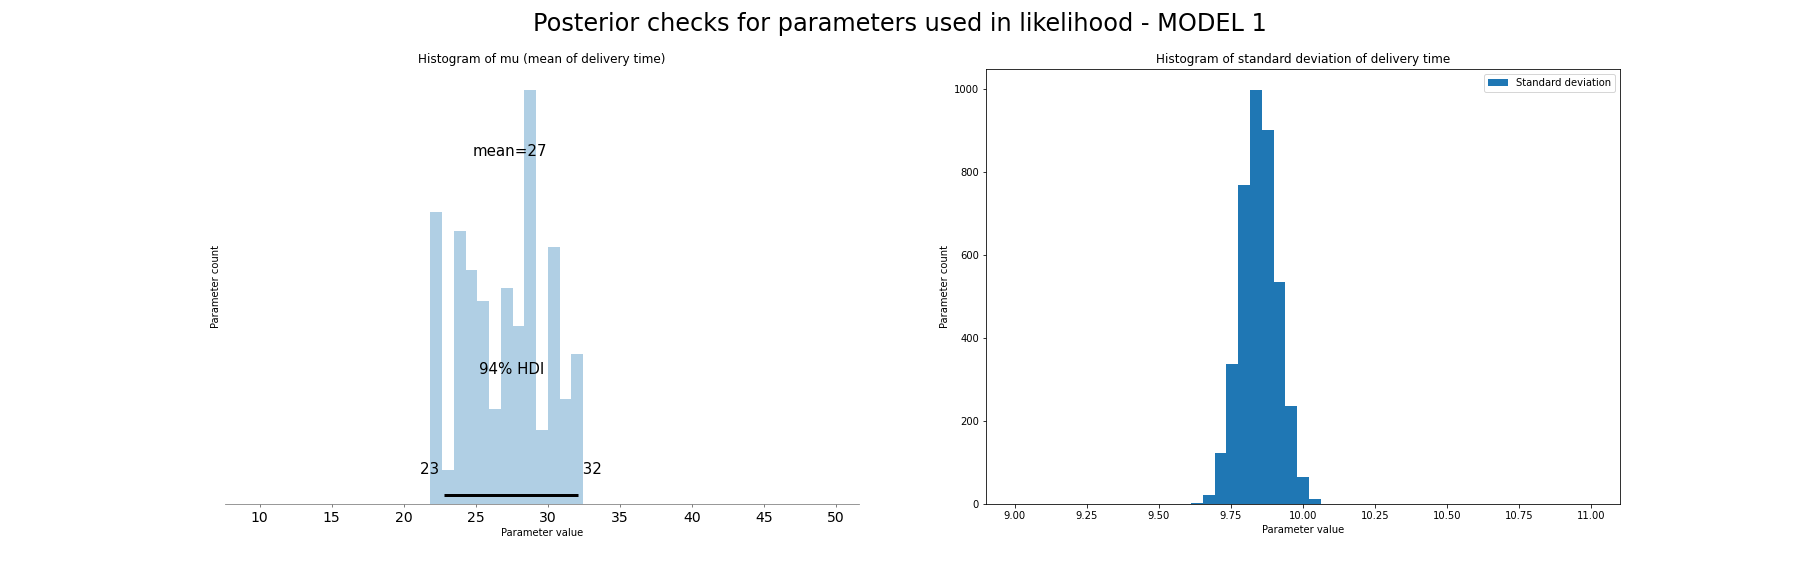 <br> <br>
$\mu$ that represents average time of delivery has all values between 20-35, which we consider very good. It's more concentated that in prior check. It doesn't follow any distribution.<br>
Parameter $\sigma$ doesn't follow prior distribution. It's concentated aroung 9.9.  and follows normal distribution.
<br><br><br><br>
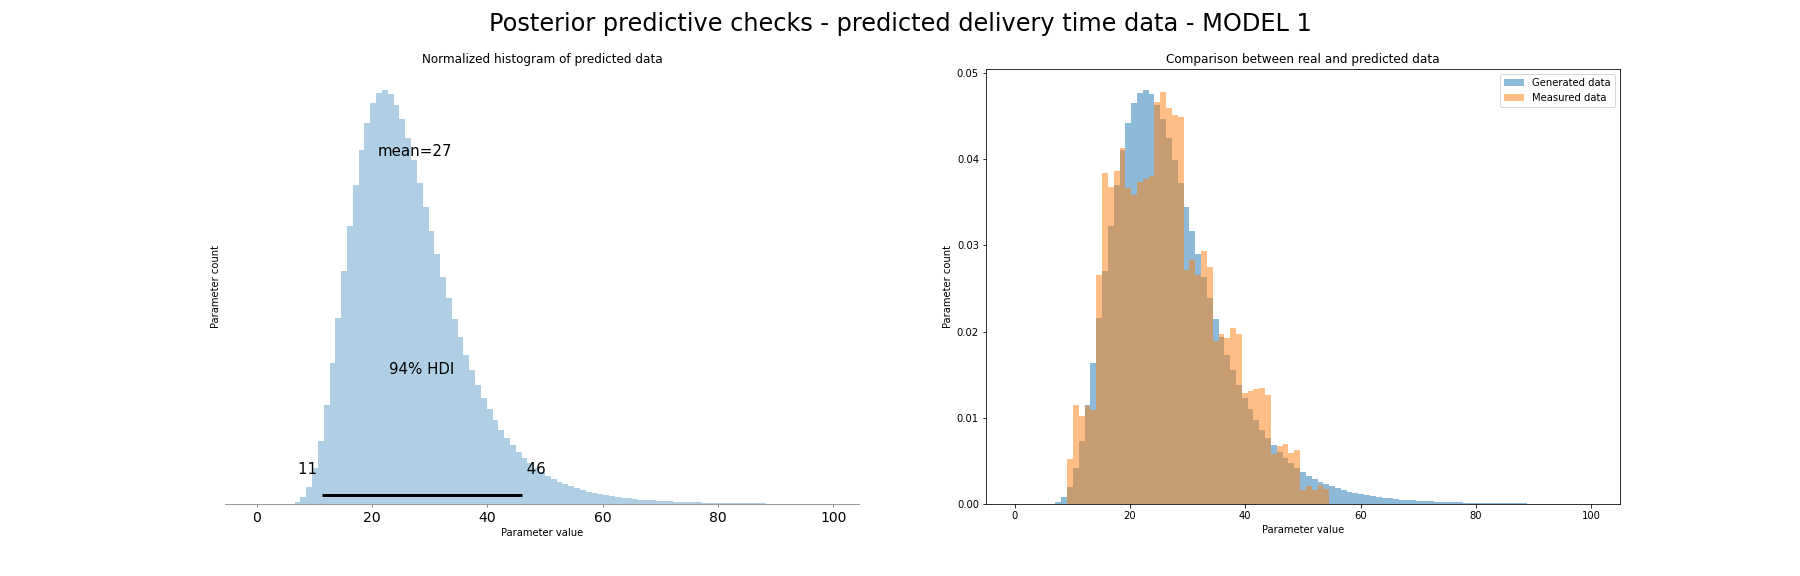<br> <br>
Predicted delivery times mostly overlap real data. The long tail is still noticeable, but most of delivery times is in 94% HDI of generated data. Some adjustments can be done to improve model - for regular cases this would be removal of the long tail.
<br>


## Issues
During sampling we had the following issues:
- poor sampling algorithm performace (high R-hat values, divergent transitions, low  E-BFMI values)
- jupter krenel crashes <br>

We used CmdStan tool diagnose() to investigate sampling problems and possible solutions. We increased number of warmup iteration, number of sampling iteration and removed wrong constraints. 
After that sampling statistics were satisfactory:

>Processing csv files: /home/project_repo/data_analytics_project/models_output/model1/fit/model1_fit-20230705202711_1.csv, /home/project_repo/data_analytics_project/models_output/model1/fit/model1_fit-20230705202711_2.csv, /home/>project_repo/data_analytics_project/models_output/model1/fit/model1_fit-20230705202711_3.csv, /home/project_repo/data_analytics_project/models_output/model1/fit/model1_fit-20230705202711_4.csv
>
>Checking sampler transitions treedepth.
>Treedepth satisfactory for all transitions.
>
>Checking sampler transitions for divergences.
>No divergent transitions found.
>
>Checking E-BFMI - sampler transitions HMC potential energy.
>E-BFMI satisfactory.
>
>Effective sample size satisfactory.
>
>Split R-hat values satisfactory all parameters.
>
>Processing complete, no problems detected.


We also had problems with jupyter kernel. While sampling all possible data (firstly we used only 1000 records) it crashes. To overcome it we prepared Python scripts that sample model's data and save results to csv files. CmdStan allowes to reproduce models from those files.


# Model 2 - Priors 
For added parameters (delivery person rating, deliveries number) we choose weakly informative priors by analogy to the first model (they also follow normal distribution with mean=0 and std=0.3). All other parameters are exactly the same as in the first model.<br><br>

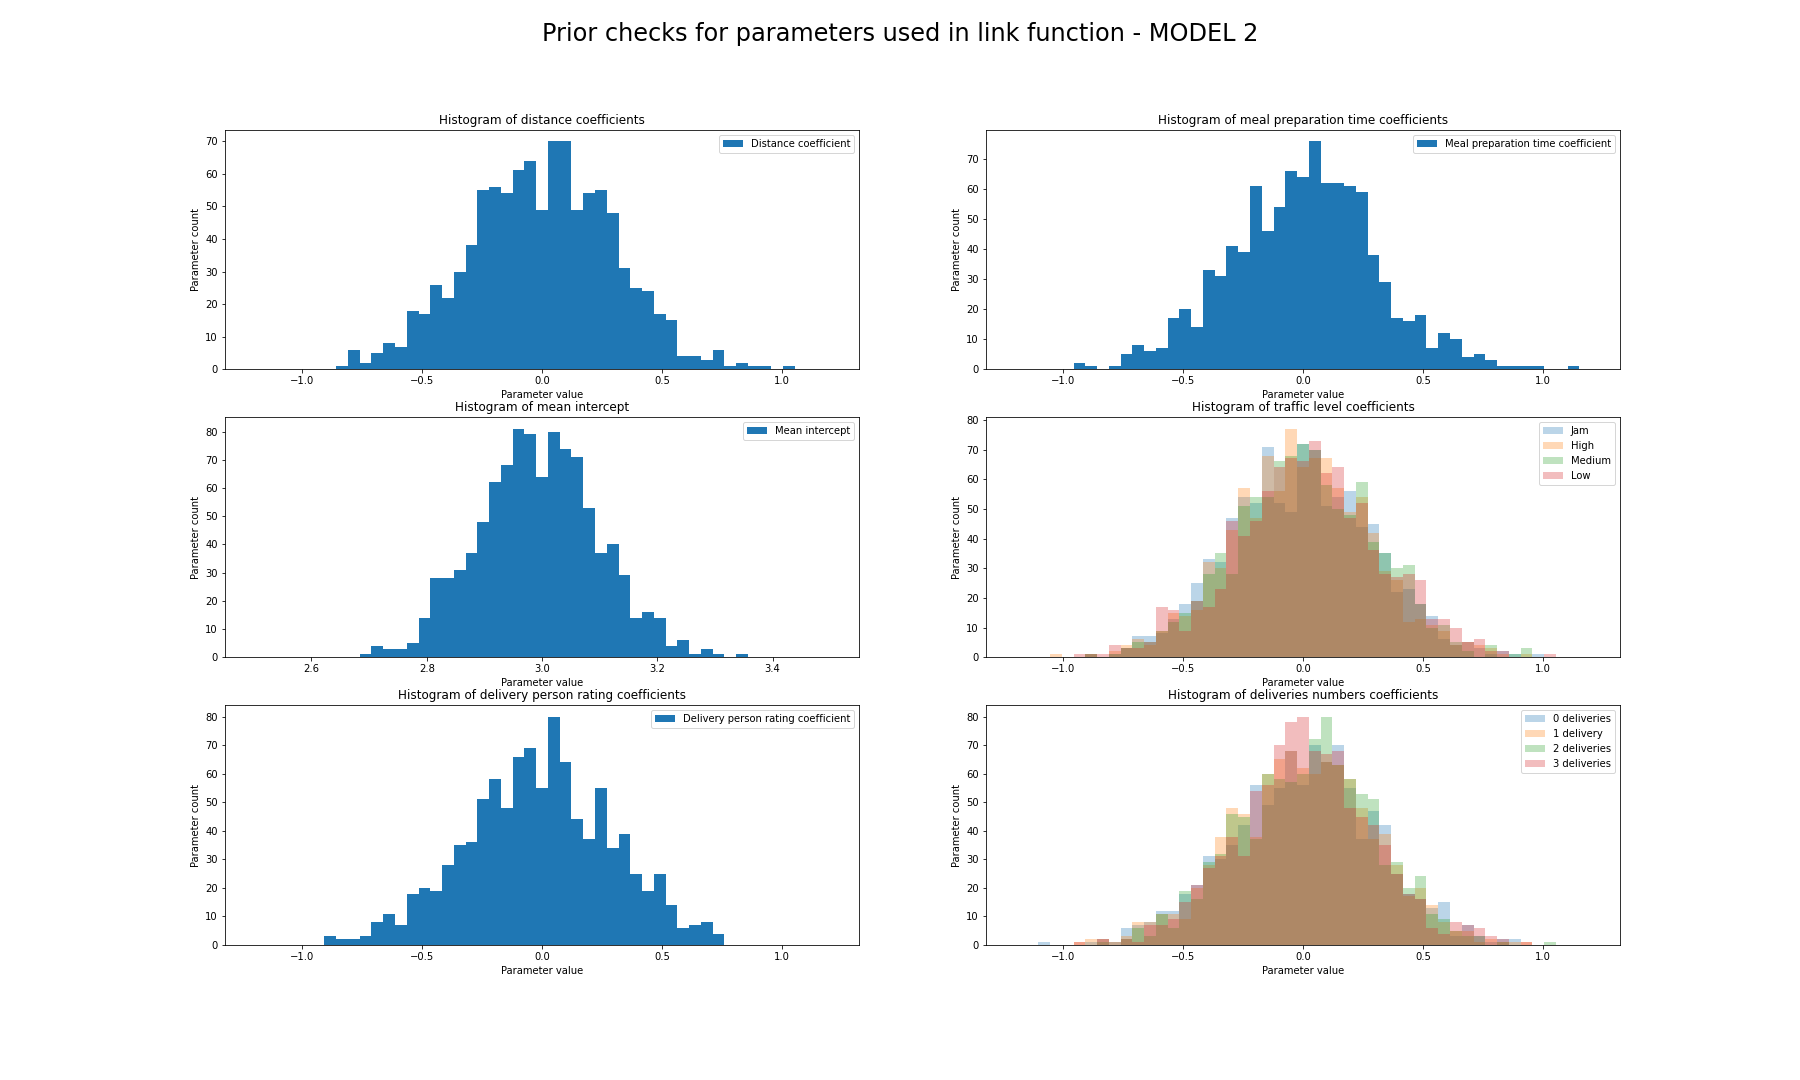<br> <br>

Values of predictors coefficients are randomly generated and there are no irregularities. <br> <br> <br> <br>
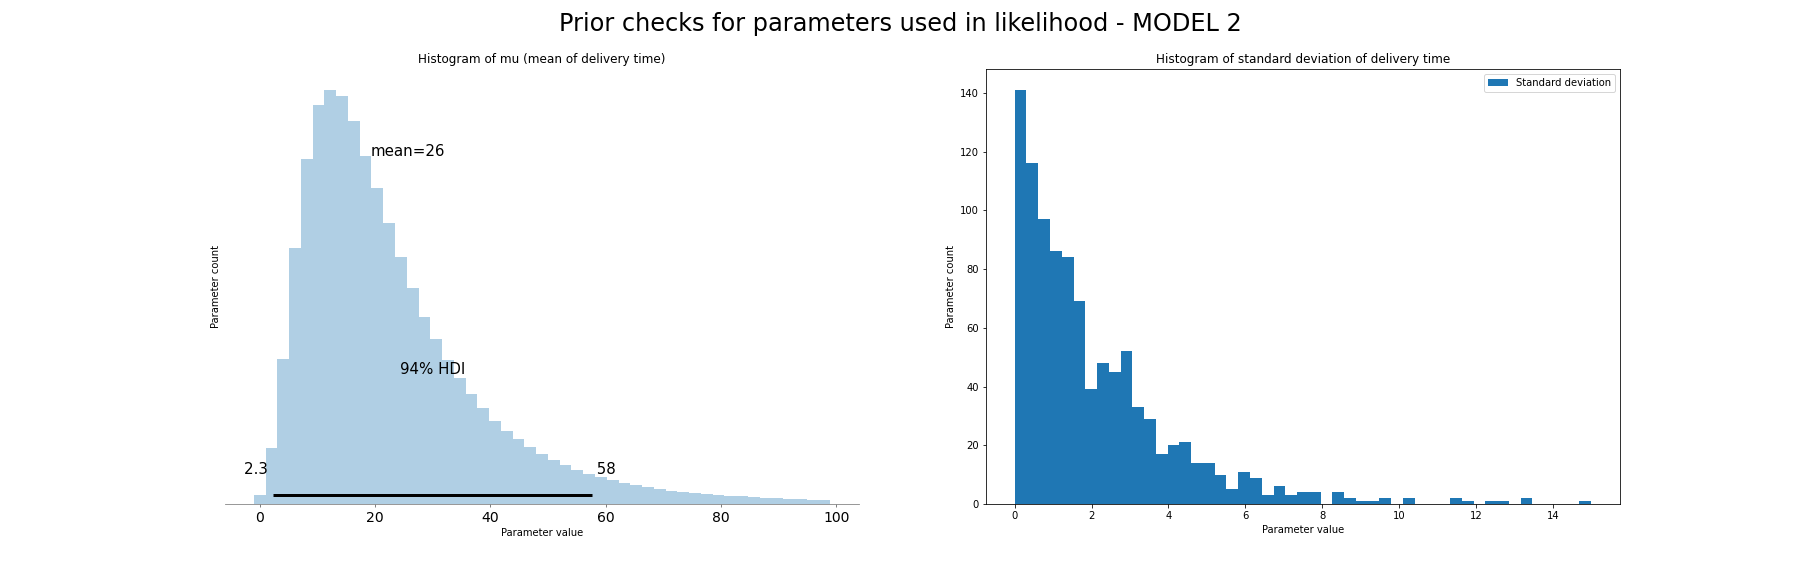 <br> <br>
Parameter $\mu$ has reasonable values, although lower bound is somewhat improbable. Distribution has long tail, but as seen on the plot 94% of its values are between 2-58. Adding extra parameters makes interval of most possible values wider. Also we didn't obtain highly improbable results (like thousands) on the upper bound. <br>
Standard deviation $\sigma$ follows its priors. 
 <br> <br> <br> <br>
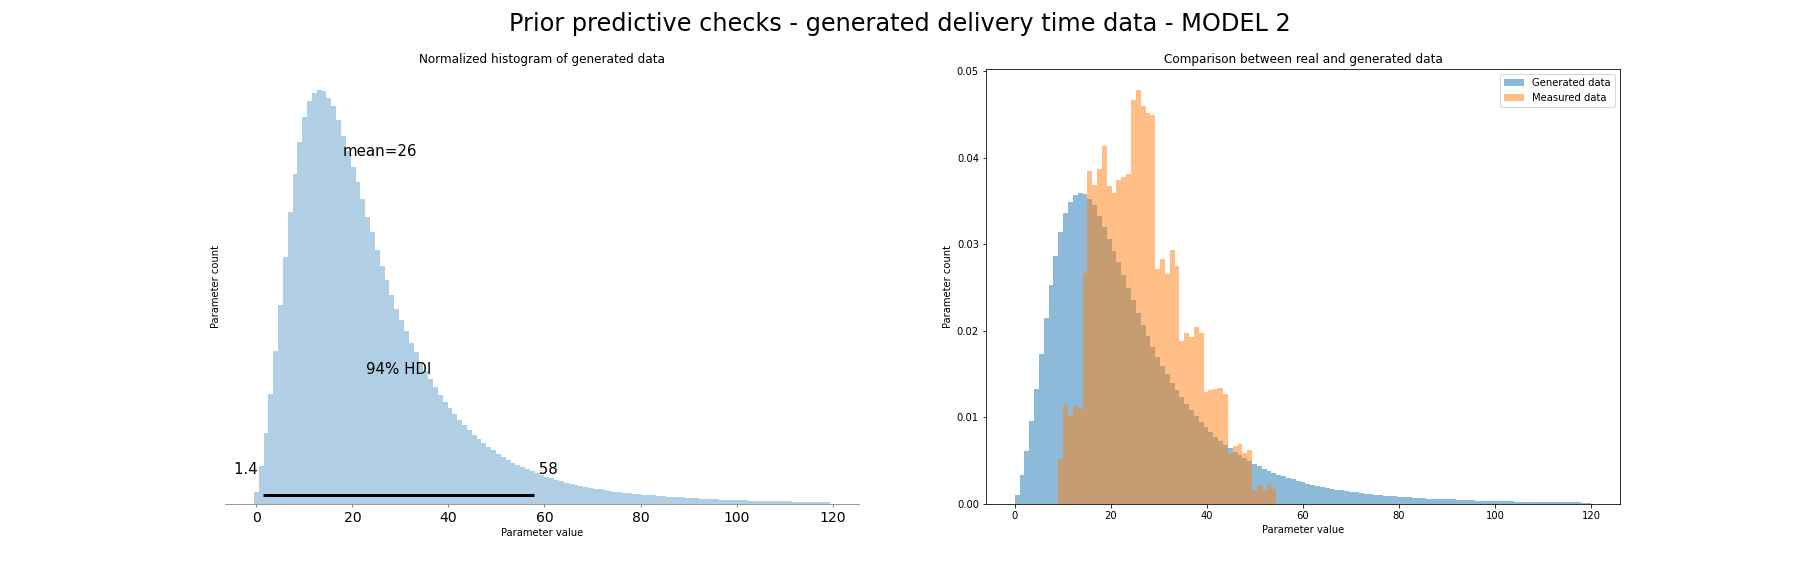<br> <br>
Real data are possible to observe in priors, which again was something we wanted to see. Longer tail is not necessarily bad, as it can account for very rare, but probable events, like road accidents.

# Model 2 - Posterior
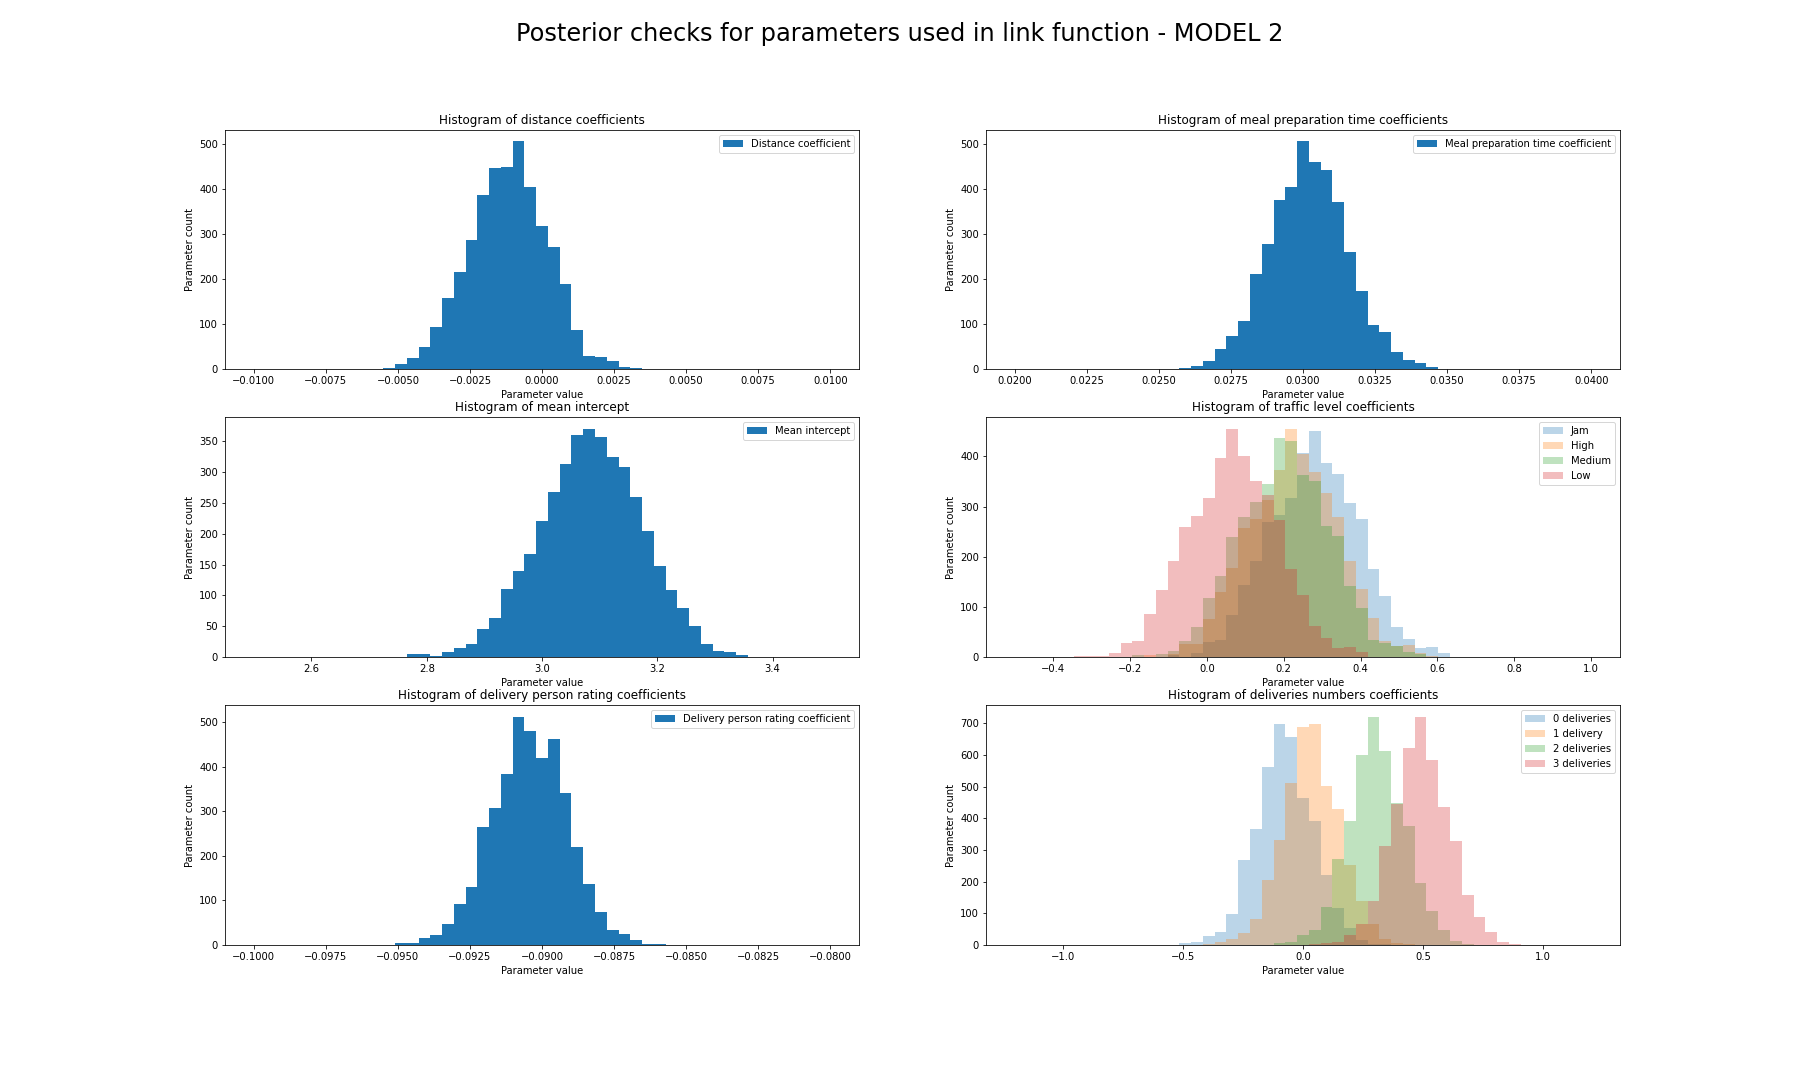<br><br>
Most of parameters coefficients has similar distributions as in first model. Meal preparation time has a little less influence in comparison to previous model and parameter mean (intercept) shifts more of its values over 3. <br>
Added parameters have expected influence. Courier rating is inversly related to delivery time. It makes sense that person with low rates would deliver food longer. Also the more deliveries the courier has the more time it will take to finish delivery.<br><br><br><br>
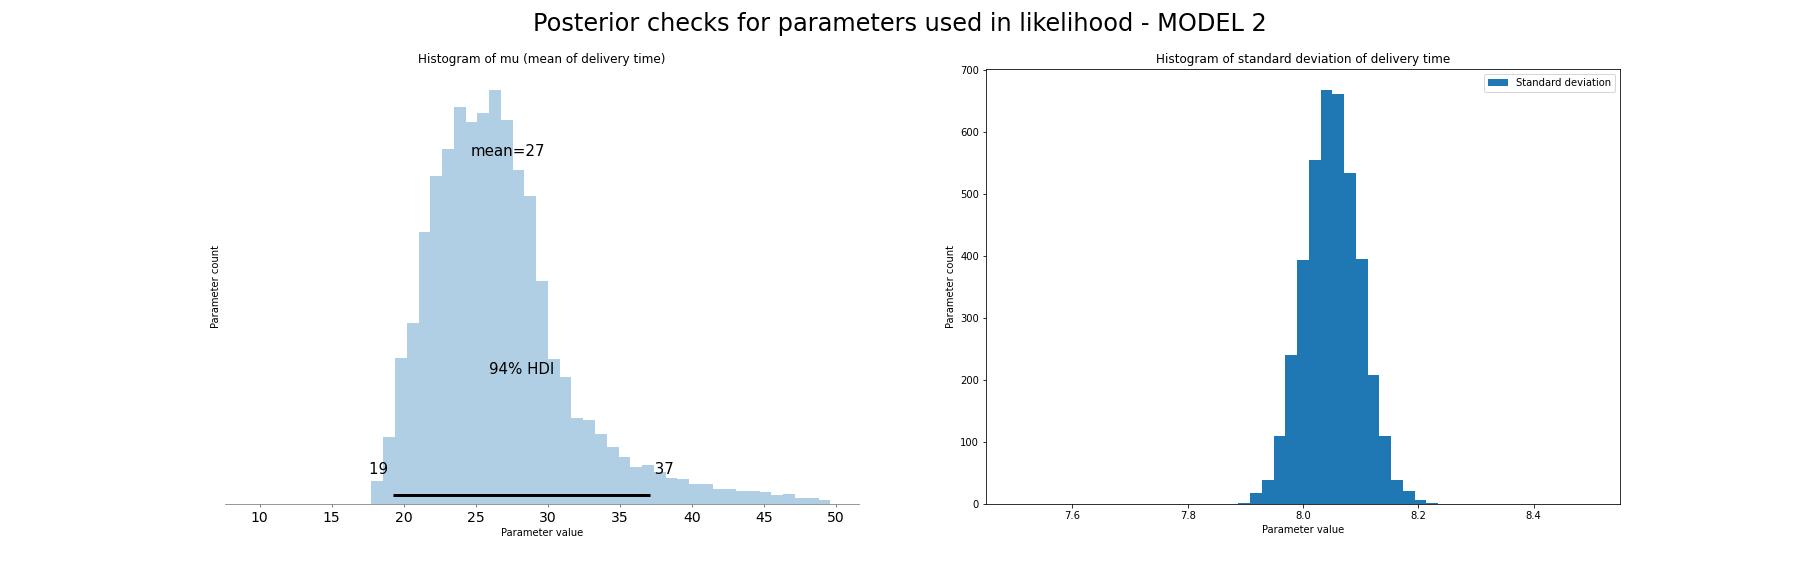<br><br>
Parameter $\mu$ has reasonable values, but the interval of values is much larger. In comparison to previous model it has noticable tail. Also the histogram of data resemble gamma distribution. <br>
Standard deviation $\sigma$ has smaller values that in first model. Data are cocentraed around 8.05 and follow normal distribution. <br><br><br><br>
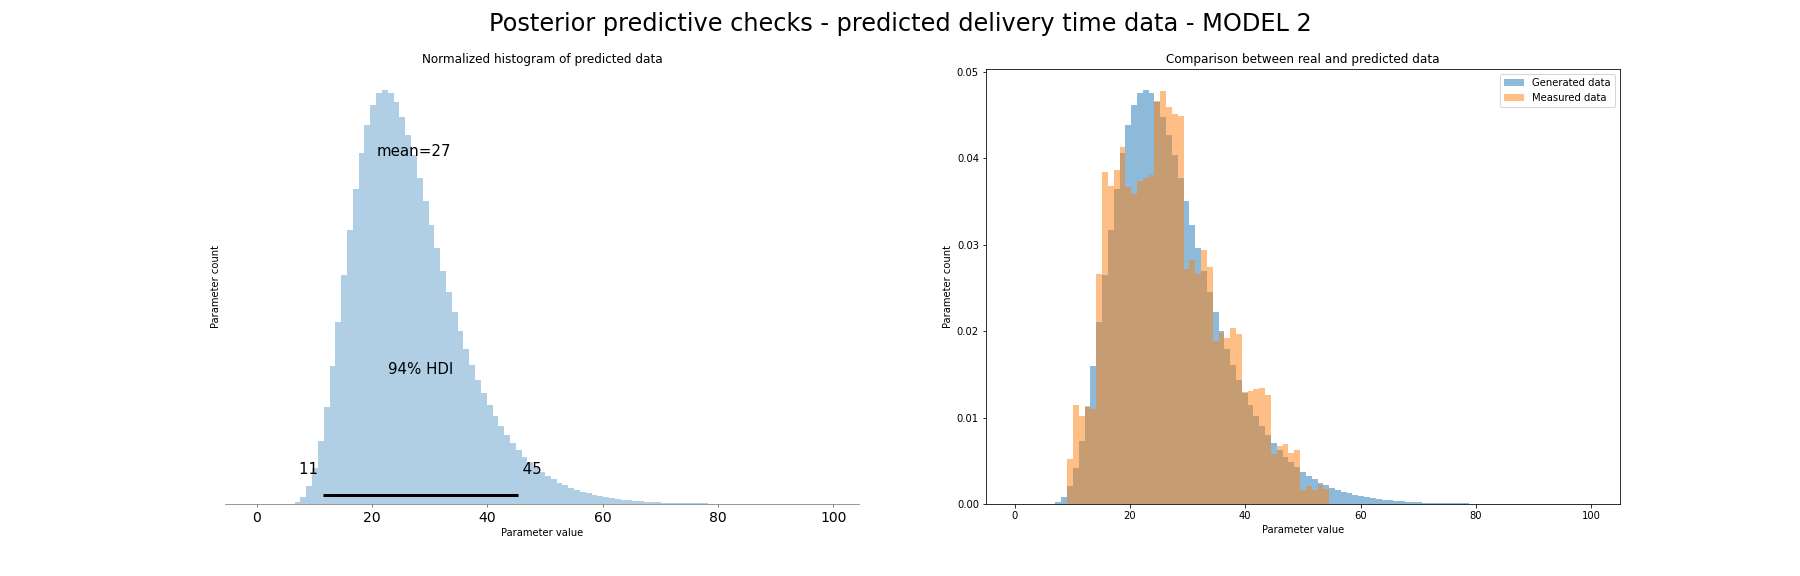<br><br>
Data generated from posterior distribution looks similar to first model. Only visible difference is that the tail is little shorter (values end before 80 rather than 90). This is beneficial for regular cases, which is majority of food delivery events.<br><br>
## Issues
Sampling was successful. Statistics are satisfactory:

>Processing csv files: /home/project_repo/data_analytics_project/models_output/model2/fit/model2_fit-20230705173419_1.csv, /home/project_repo/data_analytics_project/models_output/model2/fit/model2_fit-20230705173419_2.csv, /home/>project_repo/data_analytics_project/models_output/model2/fit/model2_fit-20230705173419_3.csv, /home/project_repo/data_analytics_project/models_output/model2/fit/model2_fit-20230705173419_4.csv
>
>Checking sampler transitions treedepth.
>Treedepth satisfactory for all transitions.
>
>Checking sampler transitions for divergences.
>No divergent transitions found.
>
>Checking E-BFMI - sampler transitions HMC potential energy.
>E-BFMI satisfactory.
>
>Effective sample size satisfactory.
>
>Split R-hat values satisfactory all parameters.
>
>Processing complete, no problems detected.<br> <br>

While sampling we have similar issue like in first model - jupyter krenel crashes. We have prepared an analogous script as for the first model.

# Model comparison

We compare models using WAIC and PSIS-LOO information criteria. 

### WAIC 

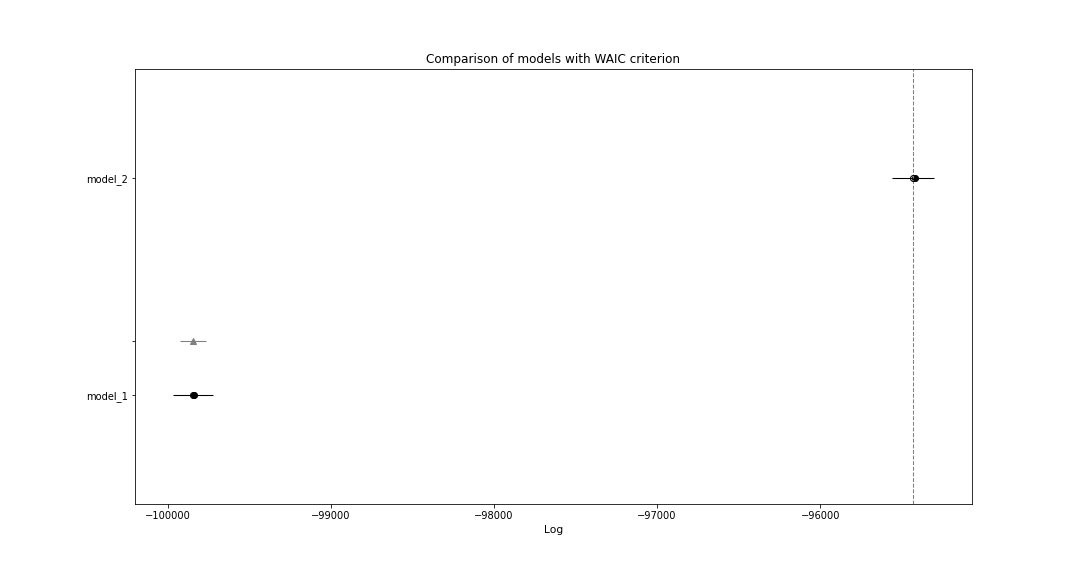 <br>

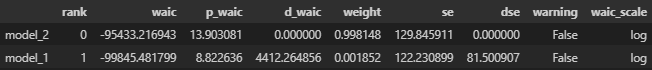 <br>

We see that from WAIC perspective clear winner is second model, as it has lower score. Given the data, second model is much more probable (0.99 weight parameter). Interestingly SE parameter is quite high, which means that the model have high uncertainty. This can be from various reasons. To name a couple:
- long tail of posterior distributions could cause uncertainty as samples can have large values,
- variability of real data, as well as problem being non-trivial could also lead to high uncertainty. 
<br>

No warnings or errors were present during evaluation.

### LOO

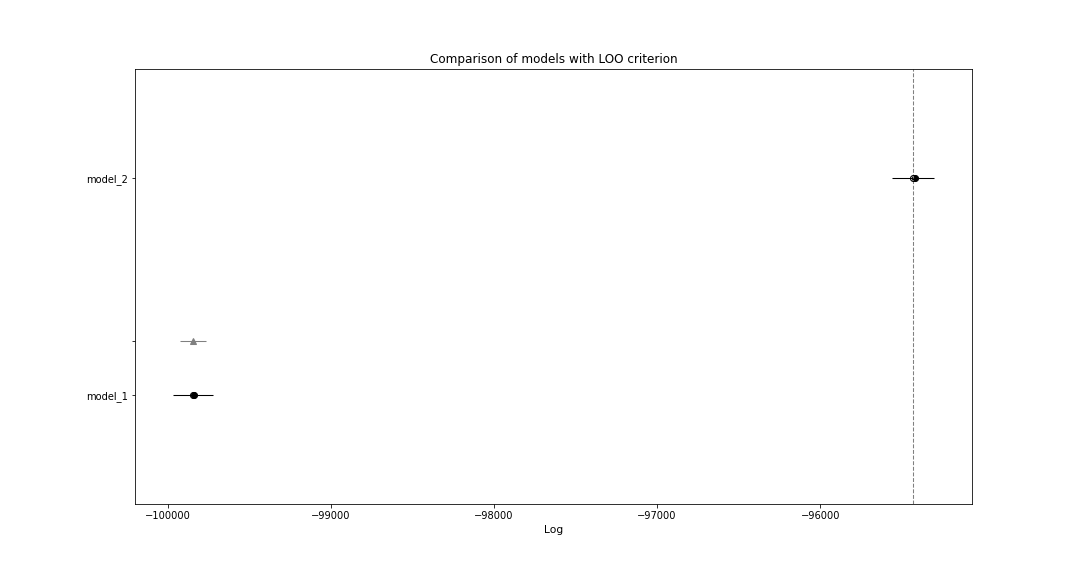 <br>

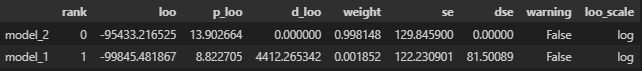

Outcome for LOO criterion is much alike the one for WAIC, values are almost identical. Here second model is better as well and is more probable.
<br>

No warnings or errors were present during evaluation.  

Based on histograms of posterior samples it is hard to tell which model proves better. From information criteria it is clear that second model is better. We agree with this outcome, as our models are heavily dependent on data and second model uses more of it. Also, as mentioned earlier, predicting food delivery time is a complex task and more advanced model is more likely to simulate that complexity. It also meets our assumptions of being an extension of the first one.